In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.3.1 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1


In [3]:
results_file = './write/pbmc3k.h5ad'

In [4]:

adata = sc.read_10x_mtx(
    './data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True) 

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [5]:
adata.var_names_make_unique()

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detectedin less than 3 cells


In [7]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [8]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [9]:
adata = adata[adata.obs.n_genes < 2500, :]
adata = adata[adata.obs.percent_mito < 0.05, :]

In [10]:
sc.pp.normalize_total(adata, target_sum=1e4)

Normalizing counts per cell.
    finished (0:00:00):normalized adata.X


In [11]:
adata.var

,gene_ids,n_cells
AL627309.1,ENSG00000237683,9
AP006222.2,ENSG00000228463,3
RP11-206L10.2,ENSG00000228327,5
RP11-206L10.9,ENSG00000237491,3
LINC00115,ENSG00000225880,18
...,...,...
AC145212.1,ENSG00000215750,16
AL592183.1,ENSG00000220023,323
AL354822.1,ENSG00000215615,8
PNRC2-1,ENSG00000215700,110


In [12]:
adata.obs

,n_genes,percent_mito,n_counts
0,,,
AAACATACAACCAC-1,781,0.030178,2419.0
AAACATTGAGCTAC-1,1352,0.037936,4903.0
AAACATTGATCAGC-1,1131,0.008897,3147.0
AAACCGTGCTTCCG-1,960,0.017431,2639.0
AAACCGTGTATGCG-1,522,0.012245,980.0
...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0
TTTCTACTGAGGCA-1,1227,0.009294,3443.0
TTTCTACTTCCTCG-1,622,0.021971,1684.0


In [13]:
sc.pp.log1p(adata)

/Users/milk/anaconda3/envs/tissue/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:285: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [14]:
adata.raw = adata

In [15]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [16]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [17]:
adata = adata[:, adata.var.highly_variable]

In [18]:
sc.pp.scale(adata, max_value=10)

/Users/milk/anaconda3/envs/tissue/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [19]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


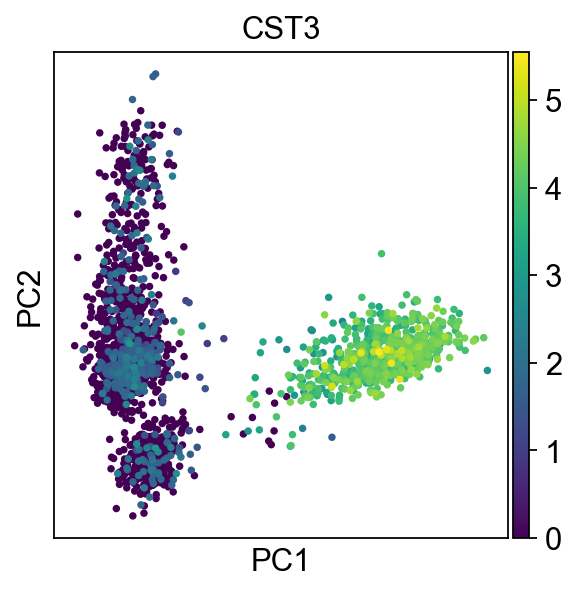

In [20]:
sc.pl.pca(adata, color='CST3')

In [23]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [25]:
adata.varm['PCs']

array([[-2.17317082e-02,  8.46073776e-03,  2.66873016e-04, ...,
        -2.51247883e-02,  9.63948574e-03,  9.48109478e-03],
       [-4.68928600e-03,  1.14918193e-02, -1.55156117e-03, ...,
         2.65515037e-02,  1.43990172e-02, -1.74628217e-02],
       [-2.71422300e-03,  3.77035164e-03,  2.95865349e-04, ...,
         1.17979543e-02,  5.91270812e-03, -5.36955427e-03],
       ...,
       [ 1.13091338e-02,  3.43348511e-05, -4.91521368e-03, ...,
         9.61822830e-03, -5.96431922e-03,  2.64653042e-02],
       [-1.07287457e-02,  4.63993289e-02,  1.27270492e-03, ...,
         3.12778763e-02, -3.00858170e-04, -1.64713468e-02],
       [-1.05221588e-02,  4.17870954e-02,  6.75286260e-03, ...,
         4.98031359e-03,  5.49898669e-03,  4.55225706e-02]])

In [20]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)


In [21]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


In [22]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [23]:
adata.uns['neighbors']

{'params': {'n_neighbors': 10,
  'method': 'umap',
  'metric': 'euclidean',
  'n_pcs': 40},
 'distances': <2638x2638 sparse matrix of type '<class 'numpy.float64'>'
 	with 23742 stored elements in Compressed Sparse Row format>,
 'connectivities': <2638x2638 sparse matrix of type '<class 'numpy.float64'>'
 	with 41518 stored elements in Compressed Sparse Row format>}

In [26]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [27]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [29]:
adata.obs['leiden']

0
AAACATACAACCAC-1    0
AAACATTGAGCTAC-1    3
AAACATTGATCAGC-1    1
AAACCGTGCTTCCG-1    5
AAACCGTGTATGCG-1    6
                   ..
TTTCGAACTCTCAT-1    2
TTTCTACTGAGGCA-1    3
TTTCTACTTCCTCG-1    3
TTTGCATGAGAGGC-1    3
TTTGCATGCCTCAC-1    0
Name: leiden, Length: 2638, dtype: category
Categories (9, object): [0, 1, 2, 3, ..., 5, 6, 7, 8]